# MSE 211 MDP Project

We can do the project here

In [1]:
from solver import Solver, CyclicVI, ClassicVI
from game import SimpleGame

# g = GridWorld(5)
g = SimpleGame()


iterators = [CyclicVI(), ClassicVI()]#[RandomVI(k=k) for k in range(1, 26, 5)]

for iterator in iterators:
    solver = Solver(iterator, g, 0.9)
    solver.solve(steps = 300)
    solver.plot_delta()

plt.legend()
plt.show()

Game over. Winer is Player 1.
OX-
-O-
-XO



TypeError: 'int' object is not subscriptable

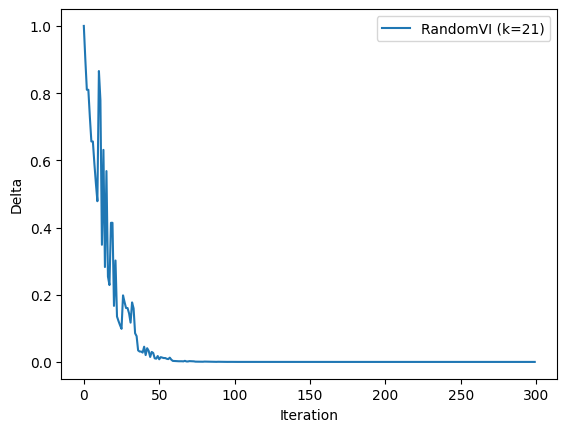

In [40]:
solver.plot_delta()
plt.legend()

In [12]:
type(iterator).__name__

'ClassicVI'

In [57]:
"""
MDPSolver:

Model/MDP
Iteration Method

Iterate until end

"""

"""
Iteration method:
Classic VI,
Random VI
Cyclic VI,
Random Cyclic VI

All iteration methods:
Take states, actions, rewards, gamma, initial values

Ouptuts
new values vector for each state
"""


"""class MDP:


    def iterate(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_random_VI(self, k):
        states = random.sample(self.states, k)

        for state in self.states:
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_cyclic_VI(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


    def iterate_cyclic_VI_random(self):
        # Get stored values
        for state in random.sample(self.states):
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


"""

'class MDP:\n\n\n    def iterate(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_random_VI(self, k):\n        states = random.sample(self.states, k)\n\n        for state in self.states:\n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_cyclic_VI(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action

In [ ]:
class MDP(ABC):
    def __init__(self, states):
        self.states = states

    @abstractmethod
    def prob(self, s, a):
        pass

    @abstractmethod
    def reward(self, s, a):
        pass

    @abc.abstractproperty
    def states(self):
        pass

